# Семинар 7 — LLM с нуля

-----

## Цель семинара

Сегодня мы реализуем минимальную, но полнофункциональную языковую модель архитектуры GPT (Generative Pre-trained Transformer). Мы пройдём путь от математических основ до работающей модели, способной генерировать текст. Вы поймёте, как устроены современные LLM изнутри.

### Что мы построим:
- **Decoder-only transformer** с causal attention
- **Positional embeddings** для кодирования позиций
- **Multi-head attention** механизм
- **Авторегрессионную генерацию** текста

### Ключевые навыки:
- Понимание математики трансформеров
- Реализация attention механизма с нуля
- Работа с маскированием для causal attention
- Различные стратегии декодирования

-----

## 0. Установка и импорт библиотек

Начнём с минимального набора библиотек. Мы намеренно НЕ используем готовые реализации трансформеров, чтобы понять их устройство.

In [ ]:
!pip install -q datasets sentencepiece

In [ ]:
# Базовые библиотеки
import os
import math
import time
import warnings, random
import numpy as np
from typing import Optional, Tuple, List
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Воспроизводимость
def seed_all(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(42)

# Включим оптимизацию для ускорения матричных вычислений на CUDA
if torch.cuda.is_available():
    import torch.backends.cuda as cuda_backends
    import torch.backends.cudnn as cudnn_backends

    # Разрешаем использование формата TF32 для ускорения операций.
    cuda_backends.matmul.allow_tf32 = True
    cudnn_backends.allow_tf32 = True

    # Устанавливаем высокую точность для вычислений с float32,
    # что позволяет использовать Тензорные ядра для ускорения
    # с минимальной потерей точности, приемлемой для большинства задач глубокого обучения.
    torch.set_float32_matmul_precision('high')

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Используем устройство: cuda
GPU: Tesla T4
Память GPU: 14.7 GB


## 1. Конфигурация модели

Определим гиперпараметры нашей модели. Это будет маленькая модель для обучения на CPU/небольшой GPU.

In [ ]:
from dataclasses import dataclass, asdict, field

@dataclass
class GPTConfig:
    """
    Конфигурация нашей мини-GPT модели
    Использование декоратора dataclass упрощает создание и управление параметрами.
    """

    # Размеры модели
    vocab_size: int = 10000      # Размер словаря
    n_embd: int = 128            # Размерность эмбеддингов (d_model) (векторного представления для каждого токена)
    n_head: int = 4              # Количество голов attention
    n_layer: int = 4             # Количество блоков трансформера
    block_size: int = 256        # Максимальная длина контекста

    # Feedforward
    n_inner: int = 512           # Размерность скрытого слоя FFN (обычно 4 * n_embd)

    # Регуляризация
    dropout: float = 0.1         # Вероятность Dropout'а

    # Параметры обучения
    learning_rate: float = 3e-4
    batch_size: int = 32
    epochs: int = 5

    def __post_init__(self):
        """
        Выполняем проверку корректности параметров после инициализации объекта.
        """
        assert self.n_embd % self.n_head == 0, "n_embd должен делиться на n_head"
        self.head_dim = self.n_embd // self.n_head

config = GPTConfig()
print("Конфигурация модели:")
for key, value in config.__dict__.items():
    print(f"  {key:15} : {value}")

Конфигурация модели:
  vocab_size      : 10000
  n_embd          : 128
  n_head          : 4
  n_layer         : 4
  block_size      : 256
  n_inner         : 512
  dropout         : 0.1
  learning_rate   : 0.0003
  batch_size      : 32
  epochs          : 5
  head_dim        : 32


## 2. Подготовка данных

Для обучения используем простой текстовый корпус. В реальности LLM обучаются на терабайтах текста, но для демонстрации достаточно небольшого датасета.

In [ ]:
from datasets import load_dataset
import re
from itertools import islice

# Загружаем датасет с прозой в "потоковом" режиме.
# Это позволяет работать с данными по частям, не загружая весь датасет в память.
proza_ds = load_dataset('cointegrated/taiga_stripped_proza', split='train', streaming=True)

# Регулярное выражение для поиска любых кириллических символов, включая букву "ё".
# Это нужно, чтобы убедиться, что в тексте есть русские слова.
cyr_re = re.compile(r'[А-Яа-яЁё]')

min_len = 200  # чтобы отсеять слишком короткий текст в датасете

text = []

for rec in proza_ds:
    t = rec.get('text', '') or ''
    if not cyr_re.search(t):
        continue
    if len(t) < min_len:
        continue
    text.append(t.strip())
    if len(text) >= 100:  # К сожалению Colab больше не вывозит. На 2000 одна эпоха будет обучатся 15 часов
        break

print(f'Загружено {len(text)} отрывков прозы')

Resolving data files:   0%|          | 0/83 [00:00<?, ?it/s]

Загружено 100 отрывков прозы


## 3. Токенизация

Реализуем простой character-level токенизатор. В production используются BPE или SentencePiece, но для понимания принципов достаточно символьной токенизации.

In [ ]:
class CharTokenizer:
    """Простой посимвольный токенизатор со спецтокенами"""

    def __init__(self, text: str, add_specials: bool = True):
        base_chars = sorted(list(set(text)))
        specials = ['<pad>', '<unk>'] if add_specials else []
        self.chars = specials + base_chars
        self.vocab_size = len(self.chars)

        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        self.pad_id = self.char_to_idx['<pad>'] if add_specials else None
        self.unk_id = self.char_to_idx['<unk>'] if add_specials else None

    def encode(self, s: str) -> List[int]:
        if self.unk_id is None:
            # без спецтокенов просто отфильтруем незнакомые
            return [self.char_to_idx[ch] for ch in s if ch in self.char_to_idx]
        return [self.char_to_idx.get(ch, self.unk_id) for ch in s]

    def decode(self, ids: List[int]) -> str:
        out = []
        for i in ids:
            ch = self.idx_to_char.get(i, '')
            if ch == '<pad>':
                continue
            out.append(ch if ch not in ('<unk>',) else '�')
        return ''.join(out)

    def __len__(self):
        return self.vocab_size

# Создаём токенизатор
full_text = "\n\n".join(text)
tokenizer = CharTokenizer(full_text)
config.vocab_size = len(tokenizer)

print(f"Размер словаря: {tokenizer.vocab_size} символов")
print(f"Примеры символов: {tokenizer.chars[:20]}")

# Тест токенизации
test_text = "Привет, мир!"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"\nТест токенизации:")
print(f"  Исходный текст: '{test_text}'")
print(f"  Токены: {encoded[:20]}...")
print(f"  Декодированный: '{decoded}'")

Размер словаря: 148 символов
Примеры символов: ['<pad>', '<unk>', '\t', '\n', ' ', '!', '"', '#', '%', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1']

Тест токенизации:
  Исходный текст: 'Привет, мир!'
  Токены: [99, 131, 123, 117, 120, 133, 14, 4, 127, 123, 131, 5]...
  Декодированный: 'Привет, мир!'


## 4. Dataset и DataLoader

Создадим PyTorch Dataset для обучения языковой модели. Каждый пример - это последовательность токенов фиксированной длины.

In [ ]:
text_orig = text.copy()
text = full_text

class TextDataset(Dataset):
    """Dataset для обучения языковой модели. Преобразует сплошной текст в набор
    пар (входная последовательность, целевая последовательность)."""

    def __init__(self, text: str, tokenizer: CharTokenizer, block_size: int):
        self.tokenizer = tokenizer
        self.block_size = block_size
        ids = tokenizer.encode(text)

        # Токенизируем весь текст
        self.data = torch.tensor(ids, dtype=torch.long)

    def __len__(self):
        # гарантируем неотрицательную длину (на случай слишком короткого текста)
        return max(0, len(self.data) - self.block_size - 1)

    def __getitem__(self, idx):
        # Для языкового моделирования (предсказание следующего токена):
        # Вход:  [x1, x2, ..., xn]
        # Выход: [x2, x3, ..., x(n+1)]
        i = idx
        j = idx + self.block_size + 1
        chunk = self.data[i:j]
        # chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # Все токены кроме последнего
        y = chunk[1:]   # Все токены кроме первого
        return x, y

# Создаём датасет
dataset = TextDataset(text, tokenizer, config.block_size)

# Настраиваем DataLoader для подачи данных в модель батчами.
loader_kwargs = dict(
    batch_size=config.batch_size,
    shuffle=True,  # Перемешиваем данные на каждой эпохе для лучшего обучения
    drop_last=True,  # Отбрасываем последний неполный батч
    pin_memory=(device.type == 'cuda'),  # ускоряет передачу данных на GPU, если используется CUDA
    num_workers=2  # включает многопоточную загрузку данных
)

dataloader = DataLoader(dataset, **loader_kwargs)

# Проверяем формат данных
x_sample, y_sample = dataset[0]
print(f"Размер датасета: {len(dataset)} примеров")
print(f"Форма входа: {x_sample.shape}")
print(f"Форма таргета: {y_sample.shape}")
print(f"\nПример (первые 5 токенов):")
print(f"Input:  {tokenizer.decode(x_sample[:5].tolist())}")
print(f"Target: {tokenizer.decode(y_sample[:5].tolist())}")

Размер датасета: 1103441 примеров
Форма входа: torch.Size([256])
Форма таргета: torch.Size([256])

Пример (первые 5 токенов):
Input:  Глава
Target: лава 


## 5. Реализация Multi-Head Attention

Сердце трансформера - механизм внимания. Повторим его реализацию с нуля как в предыдущем модуле, но теперь используя pytorch, включая "causal masking" для авторегрессионной генерации.

### Математика Attention:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Где:
- Q (Query) - что мы ищем
- K (Key) - где искать
- V (Value) - что взять

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention механизм"""

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head
        self.dropout = config.dropout

        # Линейные проекции для Q, K, V
        self.q_proj = nn.Linear(config.n_embd, config.n_embd)
        self.k_proj = nn.Linear(config.n_embd, config.n_embd)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd)

        # Выходная проекция
        self.out_proj = nn.Linear(config.n_embd, config.n_embd)

        # Dropout
        # self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        # ДЛЯ ВИЗУАЛИЗАЦИИ
        self.capture_attn = False
        self.last_attn = None

    def forward(self, x: torch.Tensor, return_attn: bool = False) -> torch.Tensor:
        B, T, C = x.shape  # batch_size, seq_len, n_embd

        # Вычисляем Q, K, V
        Q = self.q_proj(x)  # (B, T, C)
        K = self.k_proj(x)  # (B, T, C)
        V = self.v_proj(x)  # (B, T, C)

        # Разделяем на головы: (B, T, C) -> (B, n_head, T, head_dim)
        Q = Q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        need_probs = (self.capture_attn or return_attn)

        if need_probs:
            # ручной путь: считаем α-веса только когда просим визуализацию
            scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B,H,T,T)
            causal = torch.ones(T, T, device=x.device, dtype=torch.bool).tril()
            scores = scores.masked_fill(~causal, float('-inf'))
            attn_probs = F.softmax(scores, dim=-1)
            if self.training and self.dropout > 0:
                attn_probs = F.dropout(attn_probs, p=self.dropout)
            self.last_attn = attn_probs.detach().cpu()          # (B,H,T,T)
            attn = torch.matmul(attn_probs, V)                  # (B,H,T,D)
        else:
            # быстрый путь: SDPA от Pytorch 2.x сам применяет causal-mask и dropout, использует быстрые и эффективные по памяти пути
            attn = F.scaled_dot_product_attention(
                Q, K, V,
                attn_mask=None,
                dropout_p=(self.dropout if self.training else 0.0),
                is_causal=True,
            )
            self.last_attn = None

        # склейка голов
        attn = attn.transpose(1, 2).contiguous().view(B, T, C)

        out = self.out_proj(attn)
        out = self.resid_dropout(out)

        if return_attn:
            # Для визуализаций можно получить вероятности через повторный softmax,
            # но корректнее перехватывать внутри SDPA-хука; тут вернём сам выход.
            return out, None
        return out


# Тестируем attention
print("Тест Multi-Head Attention:")
test_attn = MultiHeadAttention(config).eval()
test_input = torch.randn(2, 10, config.n_embd)  # (batch_size=2, seq_len=10, n_embd)
with torch.no_grad():
  test_output = test_attn(test_input)
print(f"  Вход: {test_input.shape}")
print(f"  Выход: {test_output.shape}")
print(f"  Параметров: {sum(p.numel() for p in test_attn.parameters()):,}")

Тест Multi-Head Attention:
  Вход: torch.Size([2, 10, 128])
  Выход: torch.Size([2, 10, 128])
  Параметров: 66,048


## 6. Transformer Block

Полный transformer блок состоит из:
1. Multi-Head Attention с residual connection
2. Layer Normalization
3. Feed-Forward Network с residual connection
4. Layer Normalization

In [ ]:
class FeedForward(nn.Module):
    """
    Реализация двухслойной нейронной сети прямого распространения (FFN),
    которая применяется к каждой позиции в последовательности независимо.
    Это ключевой компонент блока трансформера.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            nn.GELU(),  # GPT-2 использовал GELU вместо ReLU из классического трансформера Если захотите современного то замените на SwiGLU/GEGLU
            nn.Linear(config.n_inner, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """Один блок transformer декодера"""

    def __init__(self, config: GPTConfig):
        super().__init__()
        # Слой нормализации
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

        # Основные компоненты
        self.attn = MultiHeadAttention(config)
        self.ffn = FeedForward(config)

    def forward(self, x):
        # Attention блок с residual connection (остаточным соединением)
        # Pre-norm architecture (как в GPT-2)
        x = x + self.attn(self.ln1(x))

        # Второй подслой: Feed-Forward Network с остаточным соединением
        x = x + self.ffn(self.ln2(x))

        return x

# Тестируем блок
print("Тест блока трансформера:")
test_block = TransformerBlock(config)
test_output = test_block(test_input)
print(f"  Вход: {test_input.shape}")
print(f"  Выход: {test_output.shape}")
print(f"  Параметров в блоке: {sum(p.numel() for p in test_block.parameters()):,}")

Тест Transformer Block:
  Вход: torch.Size([2, 10, 128])
  Выход: torch.Size([2, 10, 128])
  Параметров в блоке: 198,272


## 7. Полная модель GPT

Собираем все компоненты в единую модель:
- Token embeddings
- Positional embeddings
- Stack из transformer блоков
- Language modeling head

In [ ]:
class MiniGPT(nn.Module):
    """Минимальная реализация GPT"""

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        # Эмбеддинги для токенов
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding = nn.Embedding(config.block_size, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

        # Блоки трансформера
        self.blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layer)
        ])

        # Финальный слой нормализации перед проекцией в словарь
        self.ln_f = nn.LayerNorm(config.n_embd)

        # Голова языковой модели
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight Tying: матрица эмбеддингов и выходной слой
        # используют одни и те же веса. Это сокращает количество параметров
        # и улучшает производительность модели.
        self.lm_head.weight = self.token_embedding.weight

        # Инициализация весов
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Инициализация весов как в GPT-2"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None):
        # Прямой проход модели
        B, T = idx.shape
        assert T <= self.config.block_size, f"Sequence length {T} > block_size {self.config.block_size}"

        # Получаем эмбеддинги токенов и позиций
        pos = torch.arange(T, device=idx.device).unsqueeze(0)  # (1, T)
        x = self.token_embedding(idx) + self.position_embedding(pos)
        x = self.dropout(x)
        # pos = torch.arange(0, T, dtype=torch.long, device=idx.device).unsqueeze(0)  # (1, T)
        # tok_emb = self.token_embedding(idx)  # (B, T, n_embd)
        # pos_emb = self.position_embedding(pos)  # (1, T, n_embd)
        # x = self.dropout(tok_emb + pos_emb)

        # Пропускаем данные через все блоки трансформера
        for block in self.blocks:
            x = block(x)

        # Финальная нормализация и проекция в словарь
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        # Вычисляем loss если даны targets
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(B*T, -1),
                targets.view(B*T),
                # ignore_index=tokenizer.pad_id  # <- раскомментируй, если используешь паддинг
            )
            # B, T, C = logits.shape
            # logits_view = logits.view(B * T, C)
            # targets_view = targets.view(B * T)
            # loss = F.cross_entropy(logits_view, targets_view)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int,
                 temperature: float = 1.0, top_k: Optional[int] = None, top_p: Optional[float] = None,) -> torch.Tensor:
        """Генерация текста авторегрессионным способом"""
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-6)

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("inf")

            if top_p is not None and 0.0 < top_p < 1.0:
                sorted_logits, sorted_idx = torch.sort(logits, descending=True)
                probs = F.softmax(sorted_logits, dim=-1)
                cumprobs = torch.cumsum(probs, dim=-1)
                cutoff = (cumprobs > top_p).float().argmax(dim=-1, keepdim=True)
                # маска: всё правее порога -inf
                sorted_logits[torch.arange(sorted_logits.size(0)), cutoff.squeeze(-1)+1:] = -float("inf")
                # вернуть исходный порядок
                logits = torch.full_like(logits, -float("inf")).scatter_(1, sorted_idx, sorted_logits)

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
        # for _ in range(max_new_tokens):
        #     # Обрезаем если последовательность слишком длинная
        #     idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

        #     # Forward pass
        #     logits, _ = self(idx_cond)
        #     logits = logits[:, -1, :] / temperature  # Берём последний токен и применяем температуру

        #     # Опционально применяем top-k sampling
        #     if top_k is not None:
        #         v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        #         logits[logits < v[:, [-1]]] = -float('Inf')

        #     # Softmax и sampling
        #     probs = F.softmax(logits, dim=-1)
        #     idx_next = torch.multinomial(probs, num_samples=1)

        #     # Добавляем к последовательности
        #     idx = torch.cat((idx, idx_next), dim=1)

        # return idx


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

# Создаём модель
model = MiniGPT(config).to(device)
# model.to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nМодель MiniGPT создана:")
print(f"  Всего параметров: {total_params:,}")
print(f"  Обучаемых параметров: {trainable_params:,}")
print(f"  Размер модели: {total_params * 4 / 1024**2:.1f} MB (FP32)")

Используемое устройство: cuda

Модель MiniGPT создана:
  Всего параметров: 845,056
  Обучаемых параметров: 845,056
  Размер модели: 3.2 MB (FP32)


## 8. Обучение модели

Обучим нашу модель на подготовленном датасете. Будем отслеживать loss и периодически генерировать примеры текста.

In [ ]:
# приведем device к torch.device для избежания ошибок
if isinstance(device, str):
    device = torch.device(device)
print("device =", device, "| type:", type(device))


device = cuda | type: <class 'torch.device'>



Начинаем обучение…


Training:   0%|          | 0/34482 [00:00<?, ?it/s]

Эпоха 01 | train loss: 1.9438 | lr: 2.91e-04
Пример генерации:
 В начале было беззапрохоная услышать пропускаться, и только последние и был совсем приключить вечера по людьму. Ещё попробуй у нас мо


Training:   0%|          | 0/34482 [00:00<?, ?it/s]

Эпоха 02 | train loss: 1.5095 | lr: 2.25e-04
Пример генерации:
 В начале было выпустить над ней. Помощью с другим выстрел в своей вас принять себя не виновать, что в тот мир или у меня позволялись 


Training:   0%|          | 0/34482 [00:00<?, ?it/s]

Эпоха 03 | train loss: 1.4569 | lr: 1.24e-04
Пример генерации:
 В начале было остановиться то, что и один из них справедливости. А когда он ушёл позволить бабушке.↲↲  Девушка понимала на стол любов


Training:   0%|          | 0/34482 [00:00<?, ?it/s]

Эпоха 04 | train loss: 1.4239 | lr: 3.51e-05
Пример генерации:
 В начале было привело противника, к обрель: -- Победите, что она не успела ничего. ↲↲- А какие только у меня, - как же критерия туда 


Training:   0%|          | 0/34482 [00:00<?, ?it/s]

Эпоха 05 | train loss: 1.4050 | lr: 0.00e+00
Пример генерации:
 В начале было стоять в ремя. Она сама не заметила одна, смотрела на руку с ним. В нем было прорядок, возможно. Как бы там в момент пр


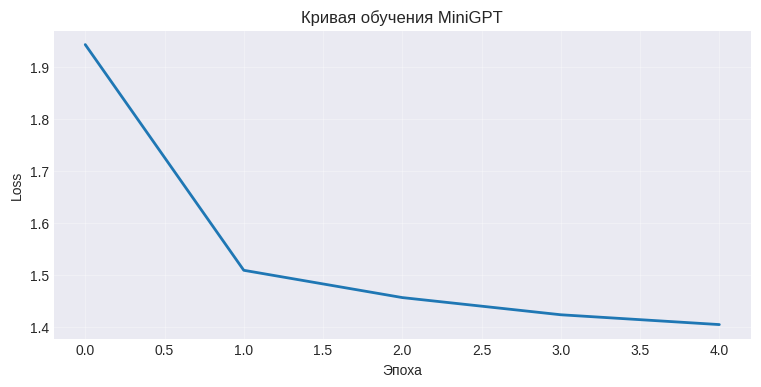

In [ ]:
from tqdm.auto import tqdm

# Создает оптимизатор AdamW с кастомной настройкой weight decay
def create_optimizer(model, lr: float = config.learning_rate, weight_decay: float = 0.1):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        # стандартный паттерн исключения из decay
        if name.endswith("bias") or "LayerNorm.weight" in name:
            no_decay.append(p)
        else:
            decay.append(p)
    param_groups = [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]
    return torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.999), eps=1e-8)

# Создает планировщик скорости обучения (learning rate scheduler): warmup + cosine затухание
def create_scheduler(optimizer, num_train_steps: int, warmup_ratio: float = 0.1):
    warmup_steps = max(1, int(num_train_steps * warmup_ratio))
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        # cosine decay до 0 после warmup
        progress = (step - warmup_steps) / float(max(1, num_train_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Одна эпоха обучения
def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer,
                scheduler=None, device: torch.device = device, max_norm: float = 1.0,
                log_every: int = 100) -> float:
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    total_loss, n_batches = 0.0, 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for step, (x, y) in enumerate(pbar, start=1):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            _, loss = model(x, targets=y)

        # Обратный проход с масштабированием лосса
        scaler.scale(loss).backward()
        # Перед клиппингом градиентов их нужно вернуть к исходному масштабу
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        # Шаг оптимизатора и обновление GradScaler
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        n_batches += 1

        if (step % log_every) == 0:
            pbar.set_postfix(loss=f"{total_loss / n_batches:.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

    return total_loss / max(1, n_batches)

@torch.no_grad()
def evaluate_epoch(model: nn.Module, dataloader: DataLoader, device: torch.device = device) -> float:
    model.eval()
    total_loss, n_batches = 0.0, 0
    for x, y in dataloader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        _, loss = model(x, targets=y)
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)

@torch.no_grad()
def generate_sample(model: nn.Module, tokenizer: CharTokenizer,
                    prompt: str = "В", max_tokens: int = 100,
                    temperature: float = 0.8, top_k: int = 50, top_p: float = 0.9) -> str:
    model.eval()
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
    out = model.generate(idx, max_new_tokens=max_tokens, temperature=temperature, top_k=top_k, top_p=top_p)
    return tokenizer.decode(out[0].tolist())

# Подготовка оптимизатора/шедулера
num_train_steps = len(dataloader) * config.epochs
optimizer = create_optimizer(model, lr=config.learning_rate, weight_decay=0.1)
scheduler = create_scheduler(optimizer, num_train_steps=num_train_steps, warmup_ratio=0.1)

# Тренировка
print("\n" + "="*50)
print("Начинаем обучение…")
print("="*50)

train_losses = []
for epoch in range(1, config.epochs + 1):
    train_loss = train_epoch(model, dataloader, optimizer, scheduler, device=device, log_every=100)
    train_losses.append(train_loss)
    print(f"Эпоха {epoch:02d} | train loss: {train_loss:.4f} | lr: {optimizer.param_groups[0]['lr']:.2e}")

    # демо-генерация
    try:
        sample = generate_sample(model, tokenizer, prompt="В начале было", max_tokens=120, temperature=0.9, top_k=50, top_p=0.9)
        print("Пример генерации:\n", sample[:400].replace("\n", "↲"))
    except Exception as e:
        print("Генерация не удалась:", e)

# График
plt.figure(figsize=(9, 4))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.title('Кривая обучения MiniGPT'); plt.grid(True, alpha=0.3)
plt.show()


## 9. Анализ и визуализация Attention

Посмотрим, что именно выучила модель. Визуализируем attention паттерны для понимания того, на что модель обращает внимание при генерации.

Визуализация attention для текста: 'Нейронные сети'


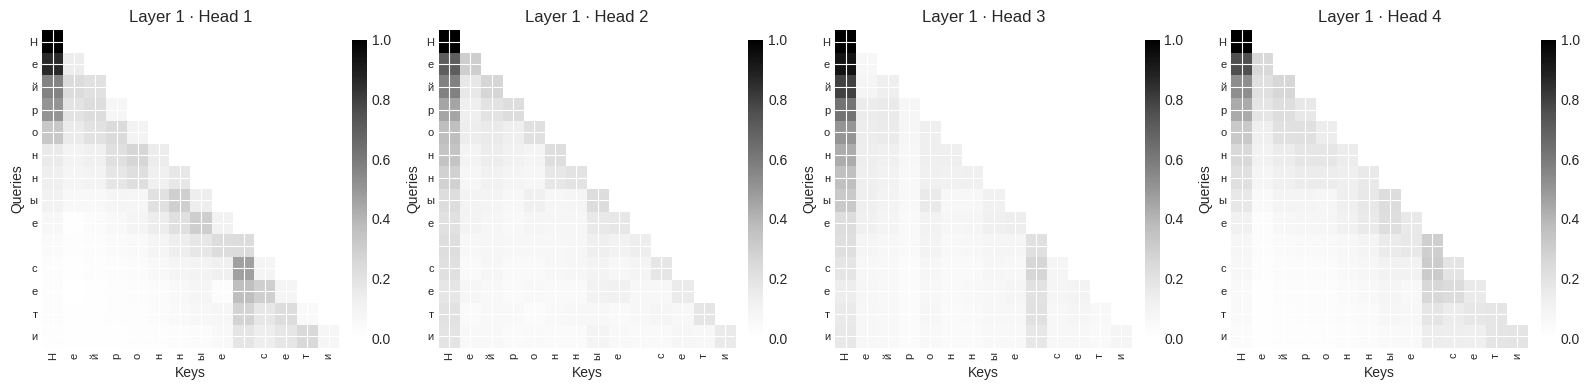

In [ ]:
@torch.no_grad()
def visualize_attention(model: nn.Module, text: str, tokenizer: CharTokenizer,
                        layer_idx: int = 0, heads_to_show: int = 4, max_len_for_plot: int = 128):
    model.eval()
    dev = next(model.parameters()).device

    ids = torch.tensor(tokenizer.encode(text), dtype=torch.long, device=dev).unsqueeze(0)
    if ids.size(1) > model.config.block_size:
        ids = ids[:, :model.config.block_size]
        text = text[:model.config.block_size]
    if ids.size(1) > max_len_for_plot:
        ids = ids[:, :max_len_for_plot]
        text = text[:max_len_for_plot]

    attn_mod = model.blocks[layer_idx].attn
    prev = attn_mod.capture_attn
    attn_mod.capture_attn = True        # включили захват
    _ = model(ids)                      # прогон вперёд
    attn = attn_mod.last_attn           # (B,H,T,T)
    attn_mod.capture_attn = prev        # вернули флаг

    if attn is None:
        print("Не удалось захватить attention-веса")
        return

    attn = attn[0]                      # (H,T,T)
    H, T, _ = attn.shape
    n = min(heads_to_show, H)

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1: axes = [axes]
    for h in range(n):
        ax = axes[h]
        im = ax.imshow(attn[h].numpy(), aspect='auto')
        ax.set_title(f'Layer {layer_idx+1} · Head {h+1}')
        ax.set_xlabel('Keys'); ax.set_ylabel('Queries')
        if T <= 40:
            ax.set_xticks(range(T)); ax.set_yticks(range(T))
            ax.set_xticklabels(list(text), rotation=90, fontsize=8)
            ax.set_yticklabels(list(text), fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# Визуализируем attention
test_text = "Нейронные сети"
print(f"Визуализация attention для текста: '{test_text}'")
visualize_attention(model, test_text, tokenizer, layer_idx=0) # МЕНЯЙТЕ СЛОИ

## 10. Различные стратегии декодирования

Изучим разные способы генерации текста:
- **Greedy decoding** - всегда выбираем наиболее вероятный токен
- **Temperature sampling** - контролируем "креативность"
- **Top-k sampling** - выбираем из k наиболее вероятных
- **Top-p (nucleus) sampling** - выбираем из токенов с суммарной вероятностью p

In [ ]:
text

'Глава первая\n\n----- . . . -----\n\nМихаил Иванович Нарывайло практически никак не среагировал на звонок телефона, указанного в рекламе детективного бюро "НикитаточкаRU". Он безучастно смотрел на не перестававший трезвонить аппарат, словно предчувствуя, что ничего хорошего, подняв трубку, не услышит. Никита, удобно устроившись на диване, пытался, как обычно, восполнить ночной недосып. Но после нескольких звонков не выдержал и с любопытством взглянул на сидевшего за столом начальника, пытаясь угадать, возьмет Нарывайло трубку сам или поручит ему это сделать.\n-- Нам звонят, шеф, -- осторожно, чтобы ненароком не навлечь на себя начальственное недовольство, негромко сказал Никита.\n-- Не слепой, слышу, -- проворчал Михаил Иванович и, выдержав продолжительную паузу в надежде, что звонки вдруг прекратятся, нехотя взял трубку. Представившись, он через мгновение перебил звонившего фразой "Одну минуту!". Затем, прикрыв микрофон рукой, произнес:\n-- Я как знал, что ничего хорошего грядущий де

In [ ]:
@torch.no_grad()
def generate_with_strategy(
    model: nn.Module,
    tokenizer: CharTokenizer,
    prompt: str = "Искусственный интеллект",
    max_tokens: int = 100,
    strategy: str = "greedy",      # "greedy" | "temperature" | "top_k" | "top_p"
    temperature: float = 1.0,
    top_k: int = 50,
    top_p: float = 0.9
) -> str:
    """Генерация с различными стратегиями декодирования (greedy / temp / top-k / nucleus)."""
    model.eval()

    # гарантируем, что device — torch.device
    dev = next(model.parameters()).device
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=dev).unsqueeze(0)

    for _ in range(max_tokens):
        # ограничиваем контекст block_size
        idx_cond = idx if idx.size(1) <= model.config.block_size else idx[:, -model.config.block_size:]

        # forward
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]  # (B=1, vocab)

        # защита от плохих параметров
        if strategy != "greedy":
            t = max(float(temperature), 1e-6)   # температура > 0
            logits = logits / t

        if strategy == "greedy":
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        elif strategy == "temperature":
            # обычный температурный сэмплинг
            # небольшой трюк для стабильности softmax
            logits = logits - logits.amax(dim=-1, keepdim=True)
            probs = F.softmax(logits, dim=-1)
            if torch.any(torch.isfinite(probs)) and torch.any(probs > 0):
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        elif strategy == "top_k":
            k = max(int(top_k), 1)
            v, _ = torch.topk(logits, min(k, logits.size(-1)))
            # зануляем всё, что ниже порога k
            logits = logits.masked_fill(logits < v[:, [-1]], float('-inf'))
            logits = logits - logits.amax(dim=-1, keepdim=True)
            probs = F.softmax(logits, dim=-1)
            if torch.any(probs > 0):
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        elif strategy == "top_p":
            # ограничиваем выборку токенами,
            # чья суммарная вероятность превышает порог P
            p = float(top_p)
            p = 1.0 if not (0.0 < p < 1.0) else p
            # сортируем по логитам убыв.
            sorted_logits, sorted_idx = torch.sort(logits, descending=True)
            sorted_logits = sorted_logits - sorted_logits.amax(dim=-1, keepdim=True)
            sorted_probs = F.softmax(sorted_logits, dim=-1)
            cumprobs = torch.cumsum(sorted_probs, dim=-1)

            # маска: всё после порога top_p — убрать
            sorted_to_remove = cumprobs > p
            # минимум 1 токен: сдвигаем маску вправо, чтобы оставить верхний
            sorted_to_remove[..., 1:] = sorted_to_remove[..., :-1].clone()
            sorted_to_remove[..., 0] = False

            # возвращаем маску к исходному порядку
            to_remove = torch.zeros_like(sorted_to_remove, dtype=torch.bool)
            to_remove = to_remove.scatter(1, sorted_idx, sorted_to_remove)

            logits = logits.masked_fill(to_remove, float('-inf'))
            logits = logits - logits.amax(dim=-1, keepdim=True)
            probs = F.softmax(logits, dim=-1)

            if torch.any(probs > 0):
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # на всякий случай fallback, если всё замаскировано
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        else:
            raise ValueError(f"Неизвестная стратегия: {strategy}")

        idx = torch.cat([idx, idx_next], dim=1)

    return tokenizer.decode(idx[0].tolist())


# Сравнение стратегий
prompt_list = [
    "Я верю в то, что совершенство возможно.",
    "Студент встал и вышел",
    "Машинное обучение",
    "Никита, удобно устроившись на диване, пытался, как обычно, восполнить ночной недосып."
]

strategies = [
    ("greedy",        {"strategy": "greedy"}),
    ("temperature=0.5", {"strategy": "temperature", "temperature": 0.5}),
    ("temperature=1.0", {"strategy": "temperature", "temperature": 1.0}),
    ("top_k=10",      {"strategy": "top_k", "top_k": 10}),
    ("top_p=0.9",     {"strategy": "top_p", "top_p": 0.9}),
]

for prm in prompt_list:
    print(f"\nPrompt: '{prm}'\n" + "="*50)
    for name, params in strategies:
        gen = generate_with_strategy(model, tokenizer, prompt=prm, max_tokens=150, **params)
        print(f"\n{name}:\n  {gen}\n" + "-"*50)



Prompt: 'Я верю в то, что совершенство возможно.'

greedy:
  Я верю в то, что совершенство возможно. Но все это время не понимает, что он не смог подумать, что он не смог подумать, что он не смог подумать, что он не смог подумать, что он не смог поду
--------------------------------------------------

temperature=0.5:
  Я верю в то, что совершенство возможно. 
Но, на какой маленькой половине на стол положение от конца поднятых ответа, а затем самого себя подумать, что с ним не стало бы ни с сердцем ни в од
--------------------------------------------------

temperature=1.0:
  Я верю в то, что совершенство возможно.
-- Спешите того, что я замечаю придумал мое лицо от того мужчин. Игорь пришёл в лечебницу, после безущего "-- потерял она перекусив руках. Он вглядыв
--------------------------------------------------

top_k=10:
  Я верю в то, что совершенство возможно. Он попросил, но к нему выводил никакой, очень был смысл, которой он не верил спросил:
-- Ну, что, я не доставал этого дого

## 11. Анализ обученной модели

Проанализируем, что выучила наша модель:
- Распределение весов
- Норма градиентов
- Качество генерации

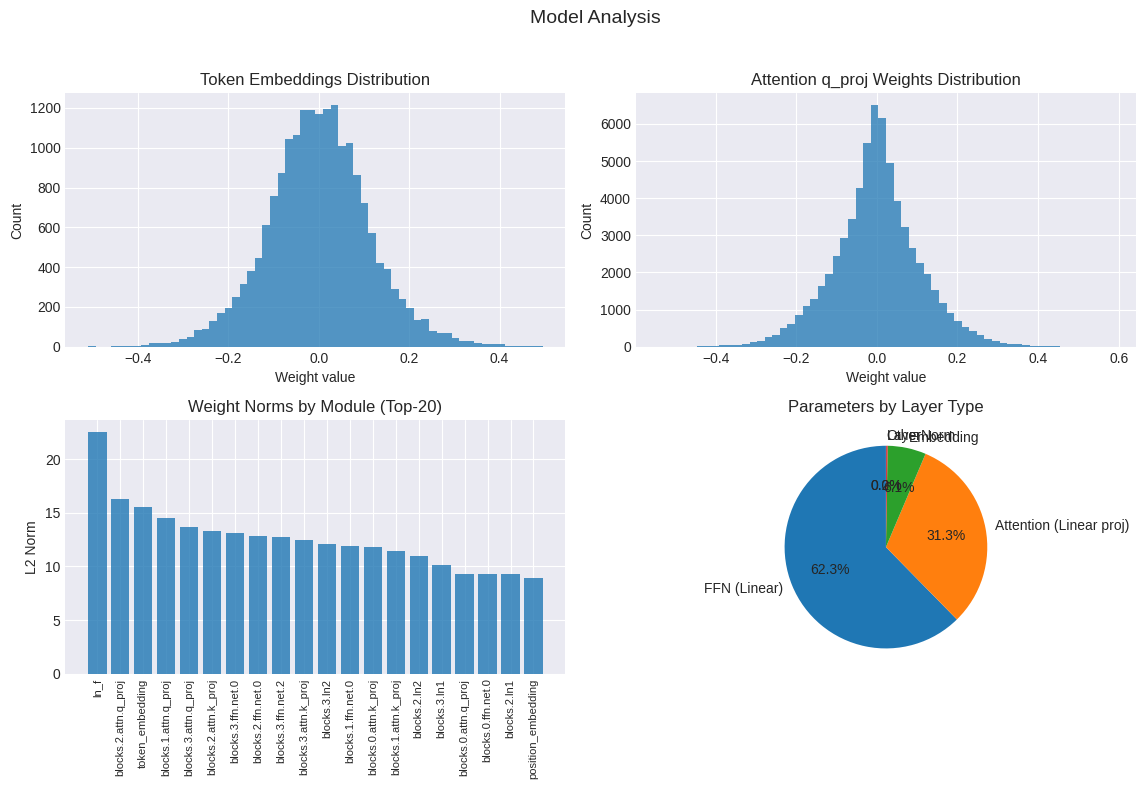


Сводка по модели:
  Параметров (trainable): 845,056
  Параметров (всего):     845,056

  Топ-5 по количеству параметров:
    blocks.0.ffn.net.0.weight: 65,536
    blocks.0.ffn.net.2.weight: 65,536
    blocks.1.ffn.net.0.weight: 65,536
    blocks.1.ffn.net.2.weight: 65,536
    blocks.2.ffn.net.0.weight: 65,536


In [ ]:
import numpy as np
from collections import defaultdict

@torch.no_grad()  # декоратор для обхода вычислений градиентов
def analyze_model(model: nn.Module):
    """Анализ параметров модели: распределения, нормы, разбивка по типам слоёв."""
    model.eval()

    # Сводка по параметрам (без .data!)
    layer_stats = {}
    for name, p in model.named_parameters():
        t = p.detach().float().cpu().view(-1)  # безопасное чтение значений
        layer_stats[name] = {
            "mean":  t.mean().item(),
            "std":   t.std(unbiased=False).item(),
            "min":   t.min().item(),
            "max":   t.max().item(),
            "shape": list(p.shape),
            "numel": p.numel(),
            "requires_grad": bool(p.requires_grad),
        }

    # Подготовка данных для графиков
    # 2.1 Embeddings
    emb_weights = None
    if hasattr(model, "token_embedding"):
        emb_weights = model.token_embedding.weight.detach().float().cpu().numpy().ravel()

    # 2.2 Attention (q_proj как репрезентативный пример)
    attn_arrays = []
    if hasattr(model, "blocks"):
        for blk in model.blocks:
            if hasattr(blk, "attn") and hasattr(blk.attn, "q_proj"):
                attn_arrays.append(blk.attn.q_proj.weight.detach().float().cpu().numpy().ravel())
    attn_weights = np.concatenate(attn_arrays) if attn_arrays else None

    # 2.3 Нормы весов по «модулю» (без дробления на .weight/.bias)
    # Используем путь до параметра без последнего сегмента
    norms = defaultdict(float)
    for name, p in model.named_parameters():
        if "weight" in name and p.requires_grad:
            mod_path = name.rsplit(".", 1)[0]  # например: blocks.0.attn.q_proj
            norms[mod_path] += p.detach().norm().item()

    # 2.4 Разбивка параметров по типам слоёв (грубая, но наглядная)
    # Лучше группировать по классам модулей, но для компактности — по имени
    type_bins = defaultdict(int)
    for name, p in model.named_parameters():
        n = name
        if n.startswith("token_embedding") or n.startswith("position_embedding"):
            key = "Embedding"
        elif ".attn." in n:
            key = "Attention (Linear proj)"
        elif ".ffn." in n:
            key = "FFN (Linear)"
        elif ".ln" in n or "LayerNorm" in n:
            key = "LayerNorm"
        elif n.startswith("lm_head"):
            key = "LM Head"
        else:
            key = "Other"
        type_bins[key] += p.numel()

    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Распределение эмбеддингов
    ax = axes[0, 0]
    if emb_weights is not None and emb_weights.size > 0:
        ax.hist(emb_weights, bins=60, alpha=0.75)
        ax.set_title("Распределение весов эмбеддингов")
    else:
        ax.text(0.5, 0.5, "Слой эмбеддингов не найден", ha='center', va='center')
    ax.set_xlabel("Веса"); ax.set_ylabel("Count")

    # Распределение attention-проекций (q_proj)
    ax = axes[0, 1]
    if attn_weights is not None and attn_weights.size > 0:
        ax.hist(attn_weights, bins=60, alpha=0.75)
        ax.set_title("Распределение весов Attention")
    else:
        ax.text(0.5, 0.5, "Слои Attention не найдены", ha='center', va='center')
    ax.set_xlabel("Веса"); ax.set_ylabel("Count")

    # Нормы весов по модулям (топ-20 для читабельности)
    ax = axes[1, 0]
    if norms:
        items = sorted(norms.items(), key=lambda x: x[1], reverse=True)[:20]
        names = [k for k, _ in items]
        vals  = [v for _, v in items]
        ax.bar(range(len(vals)), vals, alpha=0.8)
        ax.set_title("L2-нормы весов по модулям (Топ-20)")
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, rotation=90, fontsize=8)
        ax.set_ylabel("L2 норма")
    else:
        ax.text(0.5, 0.5, "Обучаемые веса не найдены", ha='center', va='center')

    # Разбивка параметров по типам слоёв
    ax = axes[1, 1]

    types_sorted = sorted(type_bins.items(), key=lambda x: x[1], reverse=True)
    if len(types_sorted) <= 6:
        labels, sizes = zip(*types_sorted)
        ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
        ax.set_title("Распределение параметров по типам слоёв")
    else:
        # агрегируем «хвост» в Other
        head, tail = types_sorted[:5], types_sorted[5:]
        head_labels, head_vals = zip(*head) if head else ([], [])
        other = sum(v for _, v in tail)
        labels = list(head_labels) + ["Other"]
        sizes  = list(head_vals) + [other]
        ax.barh(range(len(labels)), sizes, alpha=0.8)
        ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
        ax.set_title("Параметры не найдены")

    plt.suptitle("Анализ весов модели", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Сводка
    print("\nСводка по модели:")
    total_trainable = sum(stat["numel"] for stat in layer_stats.values() if stat["requires_grad"])
    total_all       = sum(stat["numel"] for stat in layer_stats.values())
    print(f"  Параметров (trainable): {total_trainable:,}")
    print(f"  Параметров (всего):     {total_all:,}")

    print("\n  Топ-5 по количеству параметров:")
    for name, stat in sorted(layer_stats.items(), key=lambda x: x[1]["numel"], reverse=True)[:5]:
        print(f"    {name}: {stat['numel']:,}")

analyze_model(model)

## 12. Сохранение и загрузка модели

Сохраним обученную модель для дальнейшего использования.

In [ ]:
import os
os.makedirs("models", exist_ok=True)

In [ ]:
from dataclasses import asdict

def save_model(model: nn.Module, tokenizer: CharTokenizer, path: str = "models/seminar_7_mini_gpt.pt"):
    """Сохранение только весов + простых метаданных (без пикла классов)"""
    ckpt = {
        "format_version": 1,
        "model_state_dict": model.state_dict(),
        "config": asdict(model.config),  # <-- словарь, не объект
        "tokenizer": {
            "chars": tokenizer.chars,
            "char_to_idx": tokenizer.char_to_idx,
            "pad_id": getattr(tokenizer, "pad_id", None),
            "unk_id": getattr(tokenizer, "unk_id", None),
        },
    }
    torch.save(ckpt, path)
    print(f"Модель сохранена в {path}")

def load_model(path: str = "models/seminar_7_mini_gpt.pt", device: torch.device | str | None = None):
    """Безопасная загрузка весов + восстановление конфига и токенизатора"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    elif isinstance(device, str):
        device = torch.device(device)

    # безопасная загрузка (PyTorch ≥ 2.1/2.2); fallback для старых
    try:
        ckpt = torch.load(path, map_location=device, weights_only=True)
    except TypeError:
        ckpt = torch.load(path, map_location=device)

    # восстановить конфиг-датакласс из словаря
    cfg_dict = ckpt["config"]
    config = GPTConfig(**cfg_dict)

    # создать модель и загрузить веса
    model = MiniGPT(config).to(device)
    model.load_state_dict(ckpt["model_state_dict"], strict=True)
    model.eval()

    # восстановить токенизатор без __init__
    tokd = ckpt["tokenizer"]
    tokenizer = CharTokenizer.__new__(CharTokenizer)
    tokenizer.chars = tokd["chars"]
    tokenizer.char_to_idx = tokd["char_to_idx"]
    tokenizer.idx_to_char = {i: ch for i, ch in enumerate(tokenizer.chars)}
    tokenizer.vocab_size = len(tokenizer.chars)
    tokenizer.pad_id = tokd.get("pad_id", None)
    tokenizer.unk_id = tokd.get("unk_id", None)

    print(f"Модель загружена из {path}")
    return model, tokenizer

# Сохранение
save_model(model, tokenizer, "models/seminar_7_mini_gpt.pt")

# Загрузка
print("\nТест загрузки модели...")
loaded_model, loaded_tokenizer = load_model("models/seminar_7_mini_gpt.pt", device=device)

# Быстрый прогон генерации
test_prompt = "Тест"
generated = generate_sample(loaded_model, loaded_tokenizer, prompt=test_prompt, max_tokens=50)
print(f"\nГенерация загруженной модели:\n  Prompt: '{test_prompt}'\n  Generated: '{generated}'")


RuntimeError: Parent directory models does not exist.

## Дополнительные материалы

### Статьи:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - оригинальная статья о Transformer
- [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165) - GPT-3
- [FlashAttention](https://arxiv.org/abs/2205.14135) - эффективная реализация attention

### Репозитории:
- [nanoGPT](https://github.com/karpathy/nanoGPT) - минималистичная реализация GPT
- [minGPT](https://github.com/karpathy/minGPT) - ещё более простая версия

### Видео:
- [Andrej Karpathy: Let's build GPT](https://www.youtube.com/watch?v=kCc8FmEb1nY)
- [3Blue1Brown: Transformers](https://www.youtube.com/watch?v=wjZofJX0v4M)

### Книги:
- [Hands-On Large Language Models](https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/)
- (https://www.piter.com/collection/soon/product/stroim-llm-s-nulya)